# Model Hubbarda

In [1]:
using LinearAlgebra
using PlotlyJS

include("hubbard_core.jl")

no_particles_from_state (generic function with 1 method)

In [3]:
t = 1
U = 1

dim_sizes = (2)
N = reduce(*, dim_sizes)
states_1d(n) = reshape(Iterators.product([[0,1] for _ in 1:2n]...) .|> collect, (1, 4^n))
my_states = states_1d(N)
next(n) = [collect(2:n); 1]
params = Params(dim_sizes, 
    [next(d) for d in dim_sizes]) 

Params(2, fill([2, 1]))

In [32]:
params.full_states[2]

2-element Vector{Vector{Int64}}:
 [1, 0]
 [0, 0]

In [31]:
move_particle(params.full_states[2], 1, 1, 2)

2-element Vector{Vector{Int64}}:
 [0, 0]
 [1, 0]

In [24]:
eigen(get_hamiltonian(params, U, t, 0))

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
16-element Vector{ComplexF64}:
    -0.7320508075688775 + 0.0im
    -0.7320508075688773 + 0.0im
    -0.6390197854113272 - 0.24322329433954124im
    -0.6390197854113272 + 0.24322329433954124im
     -0.618033988749895 + 0.0im
    -0.6180339887498949 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
 3.4764831487673373e-16 + 0.0im
     1.6180339887498945 + 0.0im
      1.618033988749897 + 0.0im
                    2.0 + 0.0im
      2.732050807568877 + 0.0im
     2.7320508075688803 + 0.0im
      4.278039570822654 + 0.0im
vectors:
16×16 Matrix{ComplexF64}:
          0.0+0.0im       0.0+0.0im  …           0.0+0.0im
 -7.70418e-16+0.0im       0.0+0.0im      4.04341e-17+0.0im
 -2.90057e-16+0.0im       0.0+0.0im     -3.97168e-18+0.0im
 -5.06177e-18+0.0im       0.0+0.0im         0.334386+0.0im
  4.93341e-16+0.0im       0.0+0.0im      4.52064e-18+0.0im
          0.0+0.0

## Zależność od potencjału chemicznego w T=0K

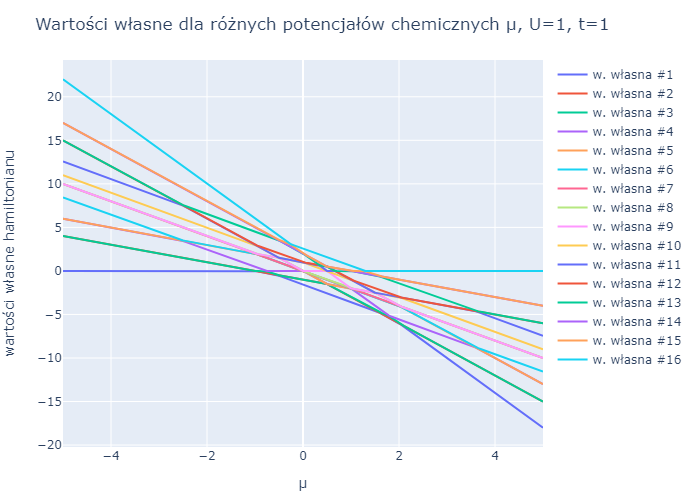

In [4]:

pot_max = 5
pot_step = 0.05
potentials = collect(-pot_max:pot_step:pot_max)
data = [eigen(get_hamiltonian(params, U, t, pot)) for pot in potentials]
eigs_mat_orig = reduce(hcat,[real(d.values) for d in data])'
eigvecs = [real(d.vectors) for d in data]
eigs_mat = [eigs_mat_orig[:,i] for i in 1:size(eigs_mat_orig,2)]
layout = Layout(
    title="Wartości własne dla różnych potencjałów chemicznych μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="wartości własne hamiltonianu",
)
pl = plot([scatter(x=potentials, y=eig, name="w. własna #$no") for (eig, no) in zip(eigs_mat, 1:(2N)^2)], layout)

In [30]:
[real(d.vectors)[:,1] for d in data][189]

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

Wybieramy stany o najmniejszej energii (dolna krawędź powyższego wykresu):

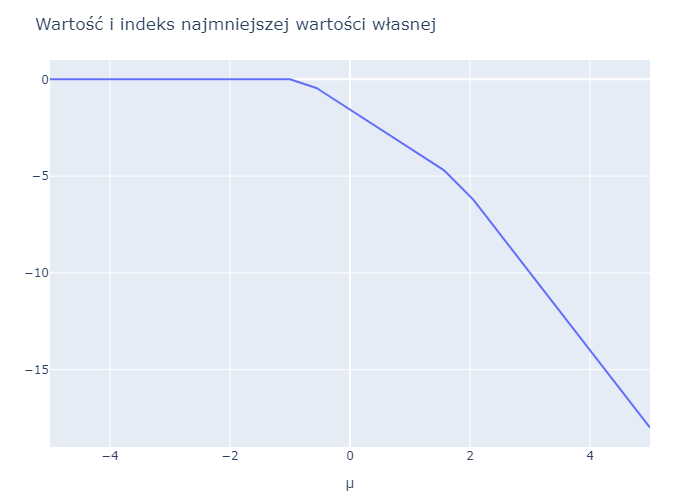

In [5]:
ground_energies = [findmin(eigs_mat_orig[i,:]) for i in 1:size(potentials,1)]
ground_energies = [g[1] for g in ground_energies]
# all_states = [real(eigvecs(get_hamiltonian(states, U, t, pot, next, N))) for pot in potentials]
ground_states = [real(d.vectors)[:,1] for d in data][1]

layout = Layout(
    title="Wartość i indeks najmniejszej wartości własnej",
    xaxis_title="μ",
)
plot(scatter(x=potentials, y=[g for g in ground_energies], name="Wartość"), layout)

Wartości własne zwizualizowane:

In [35]:
# plot([scatter(x=1:16, y=real(data[1].vectors)[1,i]) for i in 1:16])
# plot([scatter(x=1:16, y=real(eigvecs)[1,i]) for i in 1:16])
eigval_idx = 1
eigenvals_sorted = [[eigvecs[pot][:,eigval_idx][eigv] for pot in 1:201] for eigv in 1:16]
plot([scatter(x=potentials, y=tt, name=reduce(*, string.(statename))) for (tt, statename) in zip(eigenvals_sorted, states)])


UndefVarError: UndefVarError: states not defined

Średnia ilość cząstek w stanie, w zależności od potencjału chemicznego:

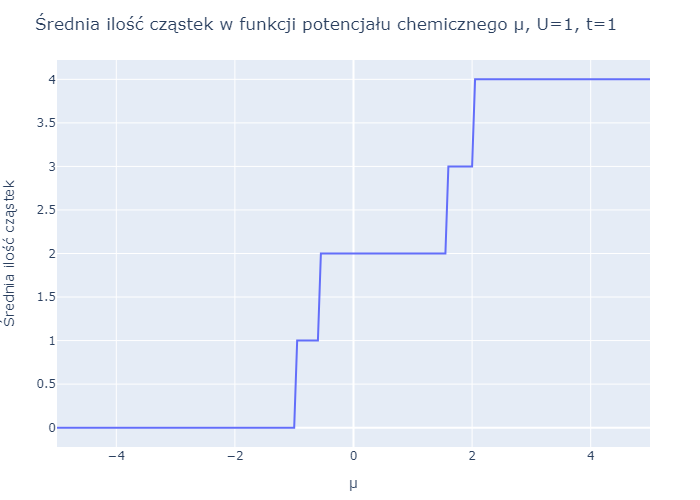

In [6]:
avg_no_particles = [[no_particles_from_state(state, N) for state in 
    [states_row[:, i] for states_row in eigvecs]] for i in 1:2^(2N)]

layout = Layout(
    title="Średnia ilość cząstek w funkcji potencjału chemicznego μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="Średnia ilość cząstek",
)
plot([scatter(x=potentials, y=avg_no_particles[1])], layout)

## Zależność temperaturowa

In [25]:
U = 1.0
t = 5.0
k = 1.0

function compute_thermodynamic_quantities(params, chem_pot, temperature, U, t)
    N = reduce(*, params.dim_sizes)
    H_matrix = get_hamiltonian(params, U, t, chem_pot)
    diagonalized = eigen(H_matrix)
    energies = diagonalized.values
    H_states = diagonalized.vectors
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    avg_particles = [no_particles_from_state(H_states[:, i], N) for i in 1:(2N)^2]
    
    densities = exp_vec ./ stat_sum
    avg_particles_temp = reduce(+, densities .* avg_particles)
    entropy = -k * reduce(+, [abs(p)*log(abs(p)) for p in densities])
    grand_potential = -k*temperature*log(stat_sum)
    return densities, avg_particles_temp, entropy, grand_potential
end

chem_potentials = -7.5:0.05:7.5
temp_range = round.(10.0.^(range(-1.5,stop=1.5,length=5)), digits=3)

thermodynamics = [[compute_thermodynamic_quantities(params, chem_pot, temperature, U, t)
        for chem_pot in chem_potentials] for temperature in temp_range]

avg_n = [[thermodynamics[j][i][2] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]
entropy_vals = [[thermodynamics[j][i][3] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]
grand_pots = [[thermodynamics[j][i][4] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]

helmholtz_vals = [[grand_pot + chem_pot*avg_no for (grand_pot, chem_pot, avg_no) in zip(grand_pot_rows, chem_potentials, avg_no_rows)] 
    for (grand_pot_rows, temp, avg_no_rows) in zip(grand_pots, temp_range, avg_n)]

U_vals = [[helm + entr*temp for (pot, helm, entr) in zip(chem_potentials, helmholtz_vals_rows, entr_rows)]
     for (temp, helmholtz_vals_rows, entr_rows) in zip(temp_range, helmholtz_vals, entropy_vals)]

5-element Vector{Vector{Float64}}:
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [-7.949827971717624e-6, -1.052810835131275e-5, -1.3942571824739104e-5, -1.8464406033034755e-5, -2.4452747851360187e-5, -3.238320535734947e-5, -4.2885628753911234e-5, -5.679412889954967e-5, -7.521331389293026e-5, -9.960600057645977e-5  …  1.9672636834547381, 1.9752486119644646, 1.9812917988458516, 1.9858628901570088, 1.9893190304046957, 1.9919313414356965, 1.993905373240166, 1.995396809205908, 1.9965234761269146, 1.997374499523327]
 [-0.7362530971378056, -0.769983125619001, -0.8050719554848171, -0.8415575881807206, -0.8794776132191764, -0.9188690570822772, -0.9597682232233391, -1.002210523581762, -1.0462303021595516, -1.0918606513502174  …  -0.8533013019584521, -0.7556170837648304, -0.6600132990062024, -0.5665245654912325, -0.47518045286021215, -0.3860054899049701, -0.29901920112389535, -0.21423617152222252, -0.13166613831410723, -0.051314107871979

Średnia ilość cząstek:

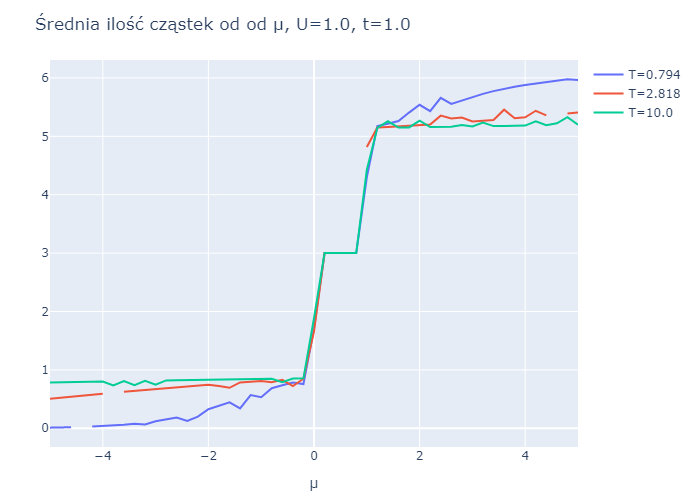

In [17]:
y_vals = real.(avg_n)

layout = Layout(
    title="Średnia ilość cząstek od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
p = plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

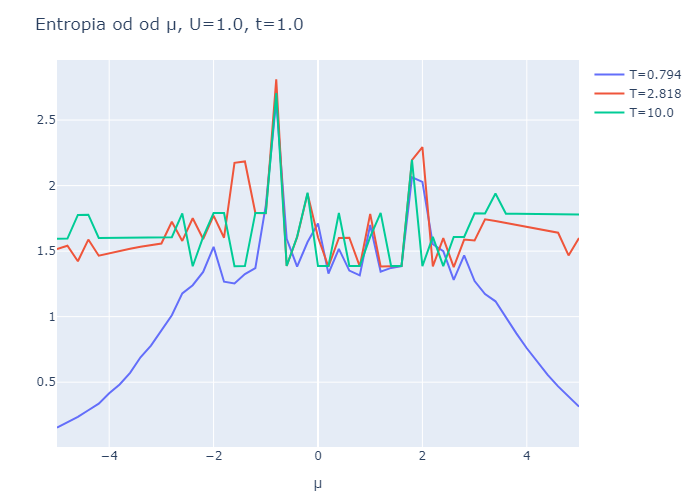

In [8]:
y_vals = entropy_vals

layout = Layout(
    title="Entropia od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

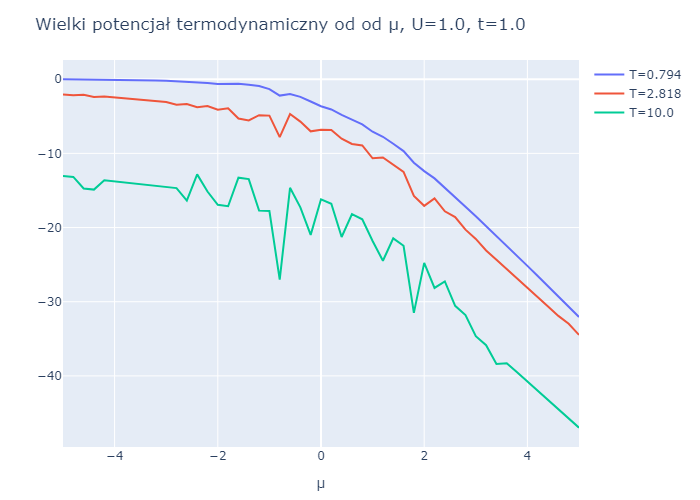

In [9]:
y_vals = grand_pots

layout = Layout(
    title="Wielki potencjał termodynamiczny od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

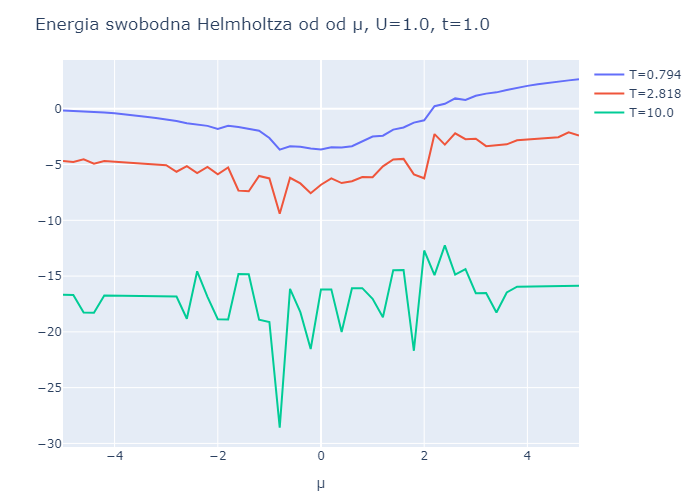

In [11]:
y_vals = real.(helmholtz_vals)

layout = Layout(
    title="Energia swobodna Helmholtza od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

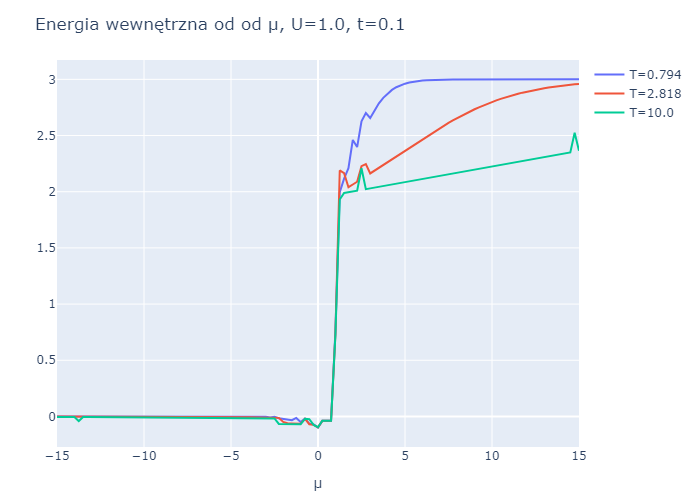

In [20]:
y_vals = U_vals

layout = Layout(
    title="Energia wewnętrzna od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

Z Lanczosem:

In [2]:
using KrylovKit

In [9]:
A = rand(200, 200) 
A = A' * A
# test1 = KrylovKit.eigsolve(A, rand(200), 10, :SR, tol=1e-4)

([0.00029487896889691956, 0.0012286754353031206, 0.007333369780150387, 0.013659521050403602, 0.016843801976881227, 0.022762502191470326, 0.0331431370937494, 0.051289979615683205, 0.06481845559140931, 0.09714392065586844, 0.09981415384773958, 0.12103309332145001, 0.15656229351602277], [[-0.07091559358700211, 0.048743687974084016, -0.13659487087191977, 0.03146488749773907, 0.11458215393837308, 0.13445121051235698, 0.13669981241408796, -0.0699841510935307, 0.07450096626996128, 0.013797449005180196  …  0.022135162495774293, -0.022604244222277563, 0.17533845882222596, -0.03434903229325569, 0.03458213352310949, 0.09498920759836581, -0.024071606247635033, -0.1106404409368071, 0.01502352722862153, -0.03520942452467946], [0.08820839669748964, -0.039630957163862744, -0.0712308732014348, 0.0240400022598155, 0.024114237216609147, -0.09273266374095741, 0.044876219305341934, 0.06188430926484433, 0.028436522755272458, -0.09814954450582984  …  0.1147205795614485, -0.011916837092449204, -0.009390932068

In [13]:
dim_sizes = (4)
N = reduce(*, dim_sizes)
states_1d(n) = reshape(Iterators.product([[0,1] for _ in 1:2n]...) .|> collect, (1, 4^n))
my_states = states_1d(N)
next(n) = [collect(2:n); 1]
params = Params(dim_sizes, [next(d) for d in dim_sizes])

Params(4, fill([2, 3, 4, 1]))

In [16]:
U = 1.0
t = 1.0
k = 1.0

function compute_thermodynamic_quantities(params, chem_pot, temperature, U, t)
    N = reduce(*, params.dim_sizes)
    H_matrix = get_hamiltonian(params, U, t, chem_pot)
    out = Array{Float64}(undef, 4N^2)
    fill!(out, NaN)
    energies, H_states, conv_info = out, out, out
    try
        energies, H_states, conv_info = eigsolve(H_matrix, 4, :SR, tol=1e-22)
    catch e
        print("Error $e at μ=$chem_pot, T=$temperature, U=$U, t=$t")
        return out, out, out, out
    end
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    avg_particles = [no_particles_from_state(H_state, N) for H_state in H_states]
    
    densities = exp_vec ./ stat_sum
    avg_particles_temp = reduce(+, densities .* avg_particles)
    entropy = -k * reduce(+, [abs(p)*log(abs(p)) for p in densities])
    grand_potential = -k*temperature*log(stat_sum)
    return densities, avg_particles_temp, entropy, grand_potential
end

chem_potentials = -5.0:0.2:5.0
temp_range = round.(10.0.^(range(-0.1,stop=1.0,length=3)), digits=3)
# compute_thermodynamic_quantities(params, 1, 1, U, t)
thermodynamics = [[compute_thermodynamic_quantities(params, chem_pot, temperature, U, t)
        for chem_pot in chem_potentials] for temperature in temp_range]

avg_n = [[thermodynamics[j][i][2] for i in eachindex(chem_potentials)] for j in eachindex(temp_range)]
entropy_vals = [[thermodynamics[j][i][3] for i in eachindex(chem_potentials)] for j in eachindex(temp_range)]
grand_pots = [[thermodynamics[j][i][4] for i in eachindex(chem_potentials)] for j in eachindex(temp_range)]

helmholtz_vals = [[grand_pot + chem_pot*avg_no for (grand_pot, chem_pot, avg_no) in zip(grand_pot_rows, chem_potentials, avg_no_rows)] 
    for (grand_pot_rows, temp, avg_no_rows) in zip(grand_pots, temp_range, avg_n)]

U_vals = [[helm + entr*temp for (pot, helm, entr) in zip(chem_potentials, helmholtz_vals_rows, entr_rows)]
     for (temp, helmholtz_vals_rows, entr_rows) in zip(temp_range, helmholtz_vals, entropy_vals)]

Error LAPACKException(1) at μ=-4.4, T=0.794, U=1.0, t=1.0

Error LAPACKException(1) at μ=-3.8, T=2.818, U=1.0, t=1.0

Error LAPACKException(1) at μ=0.8, T=2.818, U=1.0, t=1.0

Error LAPACKException(1) at μ=4.6, T=2.818, U=1.0, t=1.0

3-element Vector{Vector{T} where T}:
 Any[-1.6409928971228283e-12 - 0.0im, -2.3232238285930684e-8 - 0.0im, -2.4421992206313803e-12 - 0.0im, [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], -2.0259627309116013e-12 - 0.0im, -4.876293813182997e-12 - 0.0im, -4.240580109282632e-12 - 0.0im, -5.705047545490061e-12 - 0.0im, -3.756661648424142e-12 - 0.0im, -1.5334104158659656e-7 - 0.0im  …  2.7269139948989984 + 0.0im, 2.7739779030757266 + 0.0im, 2.8149950901695853 + 0.0im, 2.8500111989658583 + 0.0im, 2.879380642397124 + 0.0im, 2.903651089036051 + 0.0im, 2.92346299643411 + 0.0im, 2.9394739117818935 + 0.0im, 2.9755710529874517 + 0.0im, 2.96252997415533 + 0.0im]
 Any[-1.6973089600469393e-11 - 0.0im, -1.1223022511330782e-11 - 0.0im, -1.4492407274246943e-11 - 0.0im, -2.5234925260519958e-11 - 0.0im, -1.2970957641300629e-11 - 0.0im, -1.4001244608152774e-11 - 0.0im, [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN

In [10]:
compute_thermodynamic_quantities(params, 5, (10.0.^(range(-1.0,stop=1.0,length=4)))[1], U, t)

([0.9999999999998107, 9.357622968801702e-14, 9.357622968799042e-14, 2.0526184738420868e-15, 4.248354255280401e-18], 6.999999999999897 + 0.0im, 5.873455600275792e-12, -32.00000000000051)

In [99]:
N = reduce(*, params.dim_sizes)
H_matrix = get_hamiltonian(params, 1, 1, 1)
diagonalized = eigsolve(H_matrix, 4, :SR)
energies = diagonalized[1]
H_states = diagonalized[2]

6-element Vector{Vector{Float64}}:
 [4.3100595173448213e-17, -1.1009692864619532e-16, -1.909086673572859e-16, 1.8093895953984287e-17, 1.218721375976604e-16, -1.1382853078025047e-16, 2.6271564467429975e-16, -2.386443766061461e-15, 3.542220607848258e-17, -6.443991341135006e-17  …  -0.37210189349252554, 1.327643656591525e-16, -1.984147243139431e-15, -0.37210189349252504, 1.6680315511586916e-16, 4.2531340450617286e-16, 0.42430126231407134, -9.822649027113007e-17, -4.1253699054616153e-16, 5.747072375772044e-17]
 [-6.842588434995942e-18, -2.649704317846475e-16, -3.838171042693159e-16, 1.182115048983458e-17, 1.8559963538157462e-16, -9.466825088911646e-18, 2.1773585919957122e-18, 0.16966576593341964, 2.665740703513126e-16, -7.81704009358967e-19  …  7.251397929532261e-17, 3.167685991043816e-18, -0.2778460588967682, 8.745228215222213e-17, -2.466717601040049e-18, 1.1368725803423415e-17, -8.979132581649063e-17, -1.0457092582225089e-17, -1.548576540845991e-17, 8.089850364166995e-18]
 [-1.1907272900

In [2]:
mat = zeros(4^8, 4^8)
varinfo()

| name |       size | summary                     |
|:---- | ----------:|:--------------------------- |
| Base |            | Module                      |
| Core |            | Module                      |
| Main |            | Module                      |
| mat  | 32.000 GiB | 65536×65536 Matrix{Float64} |
